In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

2025-11-16 09:30:15.514836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763285415.750680      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763285415.815403      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
train_dir = '/kaggle/input/dataset-lab4-vgg/seg'
test_dir = '/kaggle/input/dataset-lab4-vgg/seg_test'

In [3]:
img_height, img_width = 224, 224
batch_size = 8  
epochs = 30
num_classes = 6

In [4]:
# Data preprocessing với augmentation cho tập train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=True,
    validation_split=0.2  # 20% cho validation
)

# Chỉ rescale cho tập test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Số lượng classes: {train_generator.num_classes}")
print(f"Classes: {train_generator.class_indices}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Số lượng classes: 6
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [5]:
# Xây dựng model VGG16
def build_vgg16_model():
    # Load VGG16 pretrained trén ImageNet
    print("Loading VGG16 pretrained weights...")
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )
    print("VGG16 base model loaded!")
    
    # Đóng băng các layers của base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Thêm các layers tùy chỉnh - VGG16
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # (None, 7, 7, 512) -> (None, 512)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Tạo model hoàn chỉnh
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [6]:
# Tạo model
model = build_vgg16_model()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Loading VGG16 pretrained weights...


I0000 00:00:1763285443.081590      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
VGG16 base model loaded!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 16,295,750 (62.16 MB)

 Trainable params: 1,581,062 (6.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# Callbacks
checkpoint = ModelCheckpoint(
    'models/vgg16_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,  # Lưu toàn bộ model
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [8]:
# Tạo thư mục lưu model
os.makedirs('models', exist_ok=True)
print("\nModels directory ready.")


Models directory ready.


In [9]:
# Training
print("BẮT ĐẦU TRAINING VGG16")
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# Lưu model cuối cùng
model.save('models/vgg16_final.h5')

BẮT ĐẦU TRAINING VGG16


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763285449.449329     126 service.cc:148] XLA service 0x7f9718003650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763285449.450449     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763285449.937410     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1404 ━━━━━━━━━━━━━━━━━━━━ 1:38 71ms/step - accuracy: 0.1042 - loss: 1.9446     

I0000 00:00:1763285454.298685     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5388 - loss: 1.1157
Epoch 1: val_accuracy improved from -inf to 0.76248, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 207s 143ms/step - accuracy: 0.5389 - loss: 1.1155 - val_accuracy: 0.7625 - val_loss: 0.6004 - learning_rate: 1.0000e-04
Epoch 2/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7776 - loss: 0.5815
Epoch 2: val_accuracy improved from 0.76248 to 0.82525, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 157s 112ms/step - accuracy: 0.7776 - loss: 0.5815 - val_accuracy: 0.8252 - val_loss: 0.4835 - learning_rate: 1.0000e-04
Epoch 3/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8130 - loss: 0.5030
Epoch 3: val_accuracy did not improve from 0.82525
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 158s 113ms/step - accuracy: 0.8130 - loss: 0.5030 - val_accuracy: 0.8149 - val_loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 4/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8211 - loss: 0.4826
Epoch 4: val_accuracy improved from 0.82525 to 0.83524, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8211 - loss: 0.4826 - val_accuracy: 0.8352 - val_loss: 0.4451 - learning_rate: 1.0000e-04
Epoch 5/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8225 - loss: 0.4786
Epoch 5: val_accuracy improved from 0.83524 to 0.83631, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 154s 110ms/step - accuracy: 0.8225 - loss: 0.4786 - val_accuracy: 0.8363 - val_loss: 0.4403 - learning_rate: 1.0000e-04
Epoch 6/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8298 - loss: 0.4496
Epoch 6: val_accuracy did not improve from 0.83631
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 109ms/step - accuracy: 0.8298 - loss: 0.4496 - val_accuracy: 0.8363 - val_loss: 0.4354 - learning_rate: 1.0000e-04
Epoch 7/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8366 - loss: 0.4469
Epoch 7: val_accuracy did not improve from 0.83631
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 151s 108ms/step - accuracy: 0.8366 - loss: 0.4469 - val_accuracy: 0.8238 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 8/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8404 - loss: 0.4339
Epoch 8: val_accuracy improved from 0.83631 to 0.84807, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 150s 107ms/step - accuracy: 0.8404 - loss: 0.4339 - val_accuracy: 0.8481 - val_loss: 0.4186 - learning_rate: 1.0000e-04
Epoch 9/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8391 - loss: 0.4282
Epoch 9: val_accuracy did not improve from 0.84807
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 151s 107ms/step - accuracy: 0.8391 - loss: 0.4282 - val_accuracy: 0.8352 - val_loss: 0.4332 - learning_rate: 1.0000e-04
Epoch 10/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8445 - loss: 0.4146
Epoch 10: val_accuracy improved from 0.84807 to 0.85093, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 149s 106ms/step - accuracy: 0.8445 - loss: 0.4145 - val_accuracy: 0.8509 - val_loss: 0.4028 - learning_rate: 1.0000e-04
Epoch 11/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8471 - loss: 0.4051
Epoch 11: val_accuracy improved from 0.85093 to 0.85449, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 150s 107ms/step - accuracy: 0.8471 - loss: 0.4051 - val_accuracy: 0.8545 - val_loss: 0.3928 - learning_rate: 1.0000e-04
Epoch 12/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8442 - loss: 0.4145
Epoch 12: val_accuracy did not improve from 0.85449
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 151s 107ms/step - accuracy: 0.8442 - loss: 0.4145 - val_accuracy: 0.8424 - val_loss: 0.4210 - learning_rate: 1.0000e-04
Epoch 13/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8441 - loss: 0.4027
Epoch 13: val_accuracy did not improve from 0.85449
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 109ms/step - accuracy: 0.8441 - loss: 0.4027 - val_accuracy: 0.8495 - val_loss: 0.4032 - learning_rate: 1.0000e-04
Epoch 14/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8525 - loss: 0.3917
Epoch 14: val_accuracy improved from 0.85449 to 0.85770, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8525 - loss: 0.3917 - val_accuracy: 0.8577 - val_loss: 0.3855 - learning_rate: 1.0000e-04
Epoch 15/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8536 - loss: 0.3899
Epoch 15: val_accuracy did not improve from 0.85770
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8536 - loss: 0.3899 - val_accuracy: 0.8442 - val_loss: 0.4148 - learning_rate: 1.0000e-04
Epoch 16/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8551 - loss: 0.3786
Epoch 16: val_accuracy did not improve from 0.85770
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 149s 106ms/step - accuracy: 0.8551 - loss: 0.3786 - val_accuracy: 0.8538 - val_loss: 0.3908 - learning_rate: 1.0000e-04
Epoch 17/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8530 - loss: 0.4059
Epoch 17: val_accuracy did not improve from 0.85770
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 108ms/step - accuracy: 0.8530 - loss: 0.4058 - val_accuracy: 0.8541 - val_loss: 0.406

1404/1404 ━━━━━━━━━━━━━━━━━━━━ 150s 107ms/step - accuracy: 0.8512 - loss: 0.3828 - val_accuracy: 0.8620 - val_loss: 0.3728 - learning_rate: 1.0000e-04
Epoch 19/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8610 - loss: 0.3618
Epoch 19: val_accuracy did not improve from 0.86198
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 150s 107ms/step - accuracy: 0.8609 - loss: 0.3618 - val_accuracy: 0.8499 - val_loss: 0.4064 - learning_rate: 1.0000e-04
Epoch 20/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8561 - loss: 0.3868
Epoch 20: val_accuracy did not improve from 0.86198
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 109ms/step - accuracy: 0.8561 - loss: 0.3868 - val_accuracy: 0.8545 - val_loss: 0.3894 - learning_rate: 1.0000e-04
Epoch 21/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8653 - loss: 0.3671
Epoch 21: val_accuracy did not improve from 0.86198
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 150s 107ms/step - accuracy: 0.8653 - loss: 0.3671 - val_accuracy: 0.8534 - val_loss: 0.376

1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 108ms/step - accuracy: 0.8571 - loss: 0.3647 - val_accuracy: 0.8641 - val_loss: 0.3688 - learning_rate: 1.0000e-04
Epoch 27/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8650 - loss: 0.3521
Epoch 27: val_accuracy improved from 0.86412 to 0.86519, saving model to models/vgg16_best.h5


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 154s 109ms/step - accuracy: 0.8650 - loss: 0.3521 - val_accuracy: 0.8652 - val_loss: 0.3787 - learning_rate: 1.0000e-04
Epoch 28/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8640 - loss: 0.3524
Epoch 28: val_accuracy did not improve from 0.86519
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 152s 108ms/step - accuracy: 0.8640 - loss: 0.3524 - val_accuracy: 0.8627 - val_loss: 0.3734 - learning_rate: 1.0000e-04
Epoch 29/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8655 - loss: 0.3559
Epoch 29: val_accuracy did not improve from 0.86519
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 150s 107ms/step - accuracy: 0.8655 - loss: 0.3559 - val_accuracy: 0.8563 - val_loss: 0.3882 - learning_rate: 1.0000e-04
Epoch 30/30
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8748 - loss: 0.3405
Epoch 30: val_accuracy did not improve from 0.86519
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.8748 - loss: 0.3405 - val_accuracy: 0.8631 - val_loss: 0.372

In [10]:
print("\n========== ĐÁNH GIÁ TRÊN TẬP TEST ==========\n")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


========== ĐÁNH GIÁ TRÊN TẬP TEST ==========

375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.8831 - loss: 0.3168
Test Loss: 0.3524
Test Accuracy: 0.8710


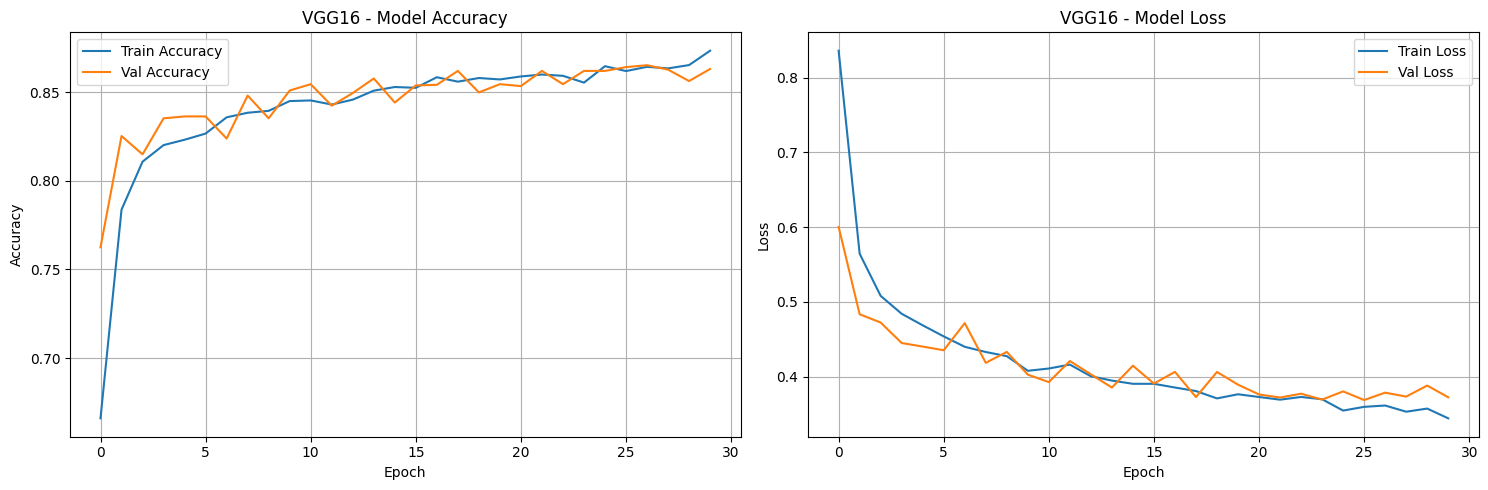

In [13]:
# Vẽ biểu đồ training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('VGG16 - Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('VGG16 - Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('results/vgg16_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()  # Đóng figure thay vì show

# Tạo thư mục results
os.makedirs('results', exist_ok=True)

# Vẽ biểu đồ
plot_training_history(history)